In [17]:
#Importing necessary library
import numpy as np
from sklearn.decomposition import SparsePCA
import matplotlib.pyplot as plt
import random
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
file = open('DataQ5.txt','r+')
reviews = file.read()
file.close()

In [19]:
reviewsList = reviews.split("\n")

In [20]:
onlyReviewsList = []
positiveNegativeList = []
for i in reviewsList:
    onlyReviewsList.append(i[0:len(i)-4].lower())
    positiveNegativeList.append(i[len(i)-1:])

N = len(onlyReviewsList)
trainSize = int(3/4 * N)
testSize = int(1/4 * N)

In [21]:
onlyReviewsList = np.array(onlyReviewsList)
positiveNegativeList = np.array(positiveNegativeList)
Tn = positiveNegativeList.astype(int)

In [22]:
vectorizer = TfidfVectorizer()
TF_IDF = vectorizer.fit_transform(onlyReviewsList)

# Part A

In [23]:
trainTF_IDF = TF_IDF[:trainSize,]
testTF_IDF = TF_IDF[trainSize:,]

# Part B

In [24]:
# Reducing the dimension to 30 using PCA    TRAIN DATA
temp = SparsePCA(n_components = 30)                               #Error Need a dense matrix
reducedTrainTF_IDF = temp.fit_transform(trainTF_IDF.toarray())              
print(reducedTrainTF_IDF.shape)

# Reducing the dimension to 30 using PCA   TEST DATA
temp = SparsePCA(n_components = 30)                               #Error Need a dense matrix
testReducedTF_IDF = temp.fit_transform(testTF_IDF.toarray())              
print(testReducedTF_IDF.shape)

(750, 30)
(250, 30)


In [25]:
#Splitting into Train and Validation
trainSize = int(5/6 * 3/4 *N)
validSize = int(1/6 * 3/4 *N)

trainReducedTF_IDF = reducedTrainTF_IDF[:trainSize,]
validReducedTF_IDF = reducedTrainTF_IDF[trainSize:,]
trainTn = Tn[:trainSize]
validTn = Tn[trainSize:trainSize + validSize]
testTn = Tn[trainSize + validSize:]

trainReducedTF_IDF = trainReducedTF_IDF.T
validReducedTF_IDF = validReducedTF_IDF.T
testReducedTF_IDF = testReducedTF_IDF.T

# Part C

In [26]:
class LogisticRegession:
    def __init__(self, nIter, batchSize, lr, regularizationCoefficient = 0):
        self.nIter = nIter
        self.batchSize = batchSize
        self.lr = lr
        self.regularizationCoefficient = regularizationCoefficient
        
        #Initialize W and b
        self.W = np.random.rand(30,1)
        self.b = np.random.rand(1,1)
        
        #Loss list
        self.lossTrain = []
        self.lossValid = []
        
    def fit(self,rcFlag=0):
        for j in range(self.nIter):
            i = 0
            while(True):
                flag = 0
                batchStartIndex = i * self.batchSize
                batchEndIndex = (i+1) * self.batchSize
                if (batchEndIndex>=trainSize):
                    batchEndIndex = trainSize
                    flag = 1
                #Forward pass
                Y = np.matmul((self.W).T, trainReducedTF_IDF) + self.b
                Y = np.exp((-1) * Y)
                Y = np.reciprocal(1 + Y)

                #Backward pass
                temp1 = Y.reshape(1,625)-trainTn.reshape(1,625)                      #temp1 = yn-tn
                temp1 = temp1[0][batchStartIndex:batchEndIndex]
                temp1 = temp1.reshape(1,batchEndIndex-batchStartIndex)

                temp2 = trainReducedTF_IDF.T[batchStartIndex:batchEndIndex,]         #temp2 = x[batchSize]

                if(rcFlag == 0):
                    self.W = self.W - self.lr * (np.matmul(temp1, temp2)).T
                else:
                    self.W = self.W - self.lr * ((np.matmul(temp1, temp2)).T + self.regularizationCoefficient * self.W)
                self.b = self.b - self.lr * np.sum(temp1)
                
                i += 1 
                if(flag==1):
                    break
            
            #Calculating Loss on Train Data
            temp3 = trainTn.reshape(1,trainSize)
            temp4 = Y.reshape(trainSize,1)
            temp5 = np.matmul(temp3,np.log(temp4))
            
            temp6 = np.full((1,trainSize),1) - temp3
            temp7 = np.full((trainSize,1),1) - temp4
            temp8 = np.matmul(temp6,np.log(temp7))

            calcLoss = -1 * (temp5 + temp8)            
            self.lossTrain.append(int(calcLoss))
            
            #Calculating Loss on Validation Data
            #Forming Y
            Y_valid = np.matmul((self.W).T, validReducedTF_IDF) + self.b
            Y_valid = np.exp((-1) * Y_valid)
            Y_valid = np.reciprocal(1 + Y_valid)
            
            temp3 = validTn.reshape(1,validSize)
            temp4 = Y_valid.reshape(validSize,1)
            temp5 = np.matmul(temp3,np.log(temp4))
            
            temp6 = np.full((1,validSize),1) - temp3
            temp7 = np.full((validSize,1),1) - temp4
            temp8 = np.matmul(temp6,np.log(temp7))

            calcLoss = -1 * (temp5 + temp8)            
            self.lossValid.append(int(calcLoss))            
            
    def predict(self):
        Y = np.matmul((self.W).T, testReducedTF_IDF) + self.b
        Y = np.exp((-1) * Y)
        Y = np.reciprocal(1 + Y)
        
        correct = 0
        total = Y.shape[1]
        predicted = []
        for i in range(total):
            if (Y[0][i]<0.5):
                predicted.append(1)
            else:
                predicted.append(0)
    
        for i in range(total):
            if(predicted[i] == int(testTn[i])):
                correct += 1
        accuracy = correct/total * 100
        print('\n'+'\033[1m' + "Review Classification Accuracy on Test Data = ", "{:.2f}".format(accuracy), " %" + '\033[0m' )
        
    def plotLossCurve(self,y,flag):
        x = [(i+1) for i in range(self.nIter)]

        plt.xlabel('#epochs')
        plt.ylabel('Loss')
        s = ""
        if (flag == 0):
            s = 'Train Data'
        else:
            s = 'Valid Data'
        plt.title('Loss Curve on ' + s)
        plt.plot(x, y)
        plt.show()
    
    def showLossValues(self,flag):
        x =[]
        if (flag == 0):
            x = self.lossTrain
            print('\033[1m' + "Loss values at each epoch for Train Data" + '\033[0m')
        else:
            x = self.lossValid
            print('\033[1m' + "Loss values at each epoch for Valid Data" + '\033[0m')
        
        for i in range(self.nIter):
            print((i+1),"th Iteration->LossValue = ", x[i])

In [27]:
epochs = 20
batchSizeList = [32, 64, 128]
LRList = [1e-3, 1e-2, 1e-1 ]

Case 1: BatchSize = 32 and Learning Rate = 0.001


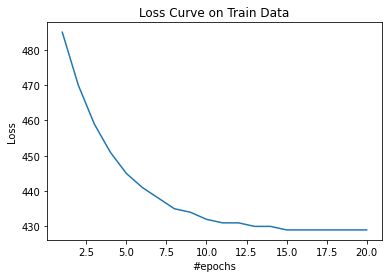

Loss values at each epoch for Train Data
1 th Iteration->LossValue =  485
2 th Iteration->LossValue =  470
3 th Iteration->LossValue =  459
4 th Iteration->LossValue =  451
5 th Iteration->LossValue =  445
6 th Iteration->LossValue =  441
7 th Iteration->LossValue =  438
8 th Iteration->LossValue =  435
9 th Iteration->LossValue =  434
10 th Iteration->LossValue =  432
11 th Iteration->LossValue =  431
12 th Iteration->LossValue =  431
13 th Iteration->LossValue =  430
14 th Iteration->LossValue =  430
15 th Iteration->LossValue =  429
16 th Iteration->LossValue =  429
17 th Iteration->LossValue =  429
18 th Iteration->LossValue =  429
19 th Iteration->LossValue =  429
20 th Iteration->LossValue =  429


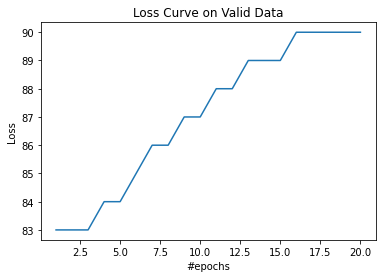

Loss values at each epoch for Valid Data
1 th Iteration->LossValue =  83
2 th Iteration->LossValue =  83
3 th Iteration->LossValue =  83
4 th Iteration->LossValue =  84
5 th Iteration->LossValue =  84
6 th Iteration->LossValue =  85
7 th Iteration->LossValue =  86
8 th Iteration->LossValue =  86
9 th Iteration->LossValue =  87
10 th Iteration->LossValue =  87
11 th Iteration->LossValue =  88
12 th Iteration->LossValue =  88
13 th Iteration->LossValue =  89
14 th Iteration->LossValue =  89
15 th Iteration->LossValue =  89
16 th Iteration->LossValue =  90
17 th Iteration->LossValue =  90
18 th Iteration->LossValue =  90
19 th Iteration->LossValue =  90
20 th Iteration->LossValue =  90

Review Classification Accuracy on Test Data =  58.80  %
------------------------------------------------------------------------------
Case 2: BatchSize = 32 and Learning Rate = 0.01


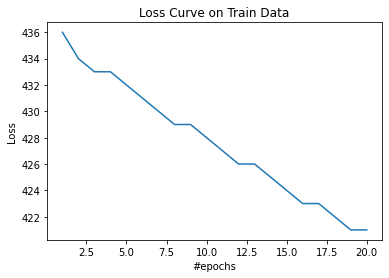

Loss values at each epoch for Train Data
1 th Iteration->LossValue =  436
2 th Iteration->LossValue =  434
3 th Iteration->LossValue =  433
4 th Iteration->LossValue =  433
5 th Iteration->LossValue =  432
6 th Iteration->LossValue =  431
7 th Iteration->LossValue =  430
8 th Iteration->LossValue =  429
9 th Iteration->LossValue =  429
10 th Iteration->LossValue =  428
11 th Iteration->LossValue =  427
12 th Iteration->LossValue =  426
13 th Iteration->LossValue =  426
14 th Iteration->LossValue =  425
15 th Iteration->LossValue =  424
16 th Iteration->LossValue =  423
17 th Iteration->LossValue =  423
18 th Iteration->LossValue =  422
19 th Iteration->LossValue =  421
20 th Iteration->LossValue =  421


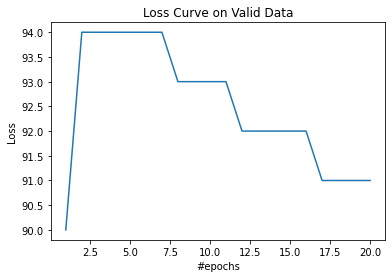

Loss values at each epoch for Valid Data
1 th Iteration->LossValue =  90
2 th Iteration->LossValue =  94
3 th Iteration->LossValue =  94
4 th Iteration->LossValue =  94
5 th Iteration->LossValue =  94
6 th Iteration->LossValue =  94
7 th Iteration->LossValue =  94
8 th Iteration->LossValue =  93
9 th Iteration->LossValue =  93
10 th Iteration->LossValue =  93
11 th Iteration->LossValue =  93
12 th Iteration->LossValue =  92
13 th Iteration->LossValue =  92
14 th Iteration->LossValue =  92
15 th Iteration->LossValue =  92
16 th Iteration->LossValue =  92
17 th Iteration->LossValue =  91
18 th Iteration->LossValue =  91
19 th Iteration->LossValue =  91
20 th Iteration->LossValue =  91

Review Classification Accuracy on Test Data =  61.20  %
------------------------------------------------------------------------------
Case 3: BatchSize = 32 and Learning Rate = 0.1


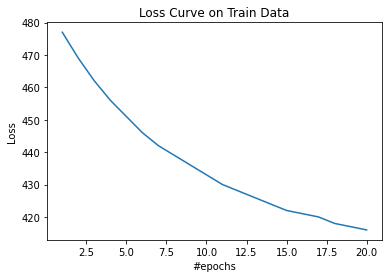

Loss values at each epoch for Train Data
1 th Iteration->LossValue =  477
2 th Iteration->LossValue =  469
3 th Iteration->LossValue =  462
4 th Iteration->LossValue =  456
5 th Iteration->LossValue =  451
6 th Iteration->LossValue =  446
7 th Iteration->LossValue =  442
8 th Iteration->LossValue =  439
9 th Iteration->LossValue =  436
10 th Iteration->LossValue =  433
11 th Iteration->LossValue =  430
12 th Iteration->LossValue =  428
13 th Iteration->LossValue =  426
14 th Iteration->LossValue =  424
15 th Iteration->LossValue =  422
16 th Iteration->LossValue =  421
17 th Iteration->LossValue =  420
18 th Iteration->LossValue =  418
19 th Iteration->LossValue =  417
20 th Iteration->LossValue =  416


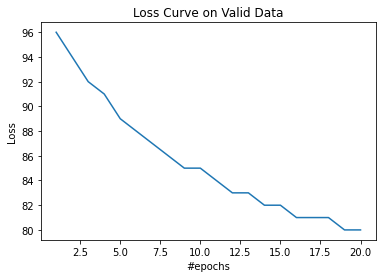

Loss values at each epoch for Valid Data
1 th Iteration->LossValue =  96
2 th Iteration->LossValue =  94
3 th Iteration->LossValue =  92
4 th Iteration->LossValue =  91
5 th Iteration->LossValue =  89
6 th Iteration->LossValue =  88
7 th Iteration->LossValue =  87
8 th Iteration->LossValue =  86
9 th Iteration->LossValue =  85
10 th Iteration->LossValue =  85
11 th Iteration->LossValue =  84
12 th Iteration->LossValue =  83
13 th Iteration->LossValue =  83
14 th Iteration->LossValue =  82
15 th Iteration->LossValue =  82
16 th Iteration->LossValue =  81
17 th Iteration->LossValue =  81
18 th Iteration->LossValue =  81
19 th Iteration->LossValue =  80
20 th Iteration->LossValue =  80

Review Classification Accuracy on Test Data =  60.80  %
------------------------------------------------------------------------------
Case 4: BatchSize = 64 and Learning Rate = 0.001


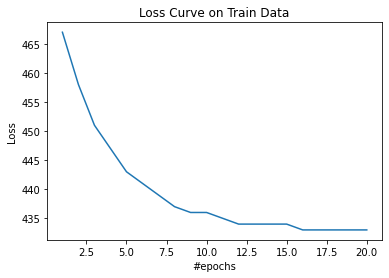

Loss values at each epoch for Train Data
1 th Iteration->LossValue =  467
2 th Iteration->LossValue =  458
3 th Iteration->LossValue =  451
4 th Iteration->LossValue =  447
5 th Iteration->LossValue =  443
6 th Iteration->LossValue =  441
7 th Iteration->LossValue =  439
8 th Iteration->LossValue =  437
9 th Iteration->LossValue =  436
10 th Iteration->LossValue =  436
11 th Iteration->LossValue =  435
12 th Iteration->LossValue =  434
13 th Iteration->LossValue =  434
14 th Iteration->LossValue =  434
15 th Iteration->LossValue =  434
16 th Iteration->LossValue =  433
17 th Iteration->LossValue =  433
18 th Iteration->LossValue =  433
19 th Iteration->LossValue =  433
20 th Iteration->LossValue =  433


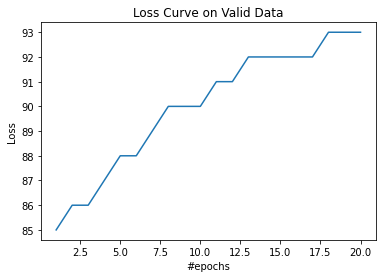

Loss values at each epoch for Valid Data
1 th Iteration->LossValue =  85
2 th Iteration->LossValue =  86
3 th Iteration->LossValue =  86
4 th Iteration->LossValue =  87
5 th Iteration->LossValue =  88
6 th Iteration->LossValue =  88
7 th Iteration->LossValue =  89
8 th Iteration->LossValue =  90
9 th Iteration->LossValue =  90
10 th Iteration->LossValue =  90
11 th Iteration->LossValue =  91
12 th Iteration->LossValue =  91
13 th Iteration->LossValue =  92
14 th Iteration->LossValue =  92
15 th Iteration->LossValue =  92
16 th Iteration->LossValue =  92
17 th Iteration->LossValue =  92
18 th Iteration->LossValue =  93
19 th Iteration->LossValue =  93
20 th Iteration->LossValue =  93

Review Classification Accuracy on Test Data =  61.20  %
------------------------------------------------------------------------------
Case 5: BatchSize = 64 and Learning Rate = 0.01


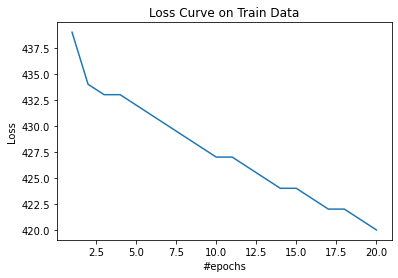

Loss values at each epoch for Train Data
1 th Iteration->LossValue =  439
2 th Iteration->LossValue =  434
3 th Iteration->LossValue =  433
4 th Iteration->LossValue =  433
5 th Iteration->LossValue =  432
6 th Iteration->LossValue =  431
7 th Iteration->LossValue =  430
8 th Iteration->LossValue =  429
9 th Iteration->LossValue =  428
10 th Iteration->LossValue =  427
11 th Iteration->LossValue =  427
12 th Iteration->LossValue =  426
13 th Iteration->LossValue =  425
14 th Iteration->LossValue =  424
15 th Iteration->LossValue =  424
16 th Iteration->LossValue =  423
17 th Iteration->LossValue =  422
18 th Iteration->LossValue =  422
19 th Iteration->LossValue =  421
20 th Iteration->LossValue =  420


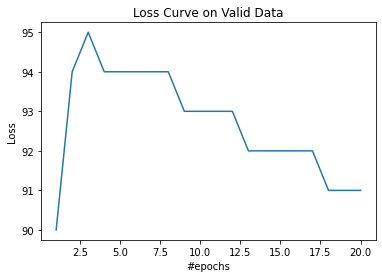

Loss values at each epoch for Valid Data
1 th Iteration->LossValue =  90
2 th Iteration->LossValue =  94
3 th Iteration->LossValue =  95
4 th Iteration->LossValue =  94
5 th Iteration->LossValue =  94
6 th Iteration->LossValue =  94
7 th Iteration->LossValue =  94
8 th Iteration->LossValue =  94
9 th Iteration->LossValue =  93
10 th Iteration->LossValue =  93
11 th Iteration->LossValue =  93
12 th Iteration->LossValue =  93
13 th Iteration->LossValue =  92
14 th Iteration->LossValue =  92
15 th Iteration->LossValue =  92
16 th Iteration->LossValue =  92
17 th Iteration->LossValue =  92
18 th Iteration->LossValue =  91
19 th Iteration->LossValue =  91
20 th Iteration->LossValue =  91

Review Classification Accuracy on Test Data =  60.80  %
------------------------------------------------------------------------------
Case 6: BatchSize = 64 and Learning Rate = 0.1


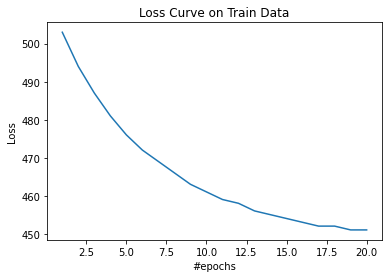

Loss values at each epoch for Train Data
1 th Iteration->LossValue =  503
2 th Iteration->LossValue =  494
3 th Iteration->LossValue =  487
4 th Iteration->LossValue =  481
5 th Iteration->LossValue =  476
6 th Iteration->LossValue =  472
7 th Iteration->LossValue =  469
8 th Iteration->LossValue =  466
9 th Iteration->LossValue =  463
10 th Iteration->LossValue =  461
11 th Iteration->LossValue =  459
12 th Iteration->LossValue =  458
13 th Iteration->LossValue =  456
14 th Iteration->LossValue =  455
15 th Iteration->LossValue =  454
16 th Iteration->LossValue =  453
17 th Iteration->LossValue =  452
18 th Iteration->LossValue =  452
19 th Iteration->LossValue =  451
20 th Iteration->LossValue =  451


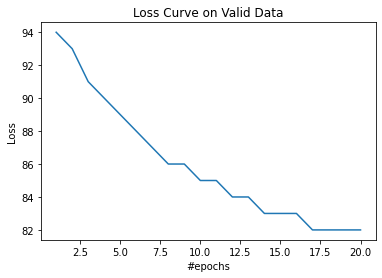

Loss values at each epoch for Valid Data
1 th Iteration->LossValue =  94
2 th Iteration->LossValue =  93
3 th Iteration->LossValue =  91
4 th Iteration->LossValue =  90
5 th Iteration->LossValue =  89
6 th Iteration->LossValue =  88
7 th Iteration->LossValue =  87
8 th Iteration->LossValue =  86
9 th Iteration->LossValue =  86
10 th Iteration->LossValue =  85
11 th Iteration->LossValue =  85
12 th Iteration->LossValue =  84
13 th Iteration->LossValue =  84
14 th Iteration->LossValue =  83
15 th Iteration->LossValue =  83
16 th Iteration->LossValue =  83
17 th Iteration->LossValue =  82
18 th Iteration->LossValue =  82
19 th Iteration->LossValue =  82
20 th Iteration->LossValue =  82

Review Classification Accuracy on Test Data =  59.60  %
------------------------------------------------------------------------------
Case 7: BatchSize = 128 and Learning Rate = 0.001


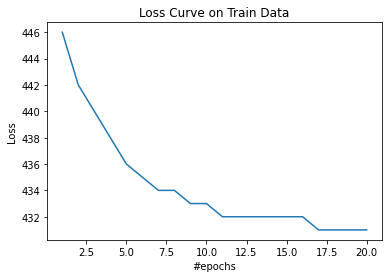

Loss values at each epoch for Train Data
1 th Iteration->LossValue =  446
2 th Iteration->LossValue =  442
3 th Iteration->LossValue =  440
4 th Iteration->LossValue =  438
5 th Iteration->LossValue =  436
6 th Iteration->LossValue =  435
7 th Iteration->LossValue =  434
8 th Iteration->LossValue =  434
9 th Iteration->LossValue =  433
10 th Iteration->LossValue =  433
11 th Iteration->LossValue =  432
12 th Iteration->LossValue =  432
13 th Iteration->LossValue =  432
14 th Iteration->LossValue =  432
15 th Iteration->LossValue =  432
16 th Iteration->LossValue =  432
17 th Iteration->LossValue =  431
18 th Iteration->LossValue =  431
19 th Iteration->LossValue =  431
20 th Iteration->LossValue =  431


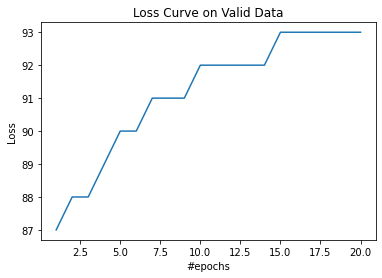

Loss values at each epoch for Valid Data
1 th Iteration->LossValue =  87
2 th Iteration->LossValue =  88
3 th Iteration->LossValue =  88
4 th Iteration->LossValue =  89
5 th Iteration->LossValue =  90
6 th Iteration->LossValue =  90
7 th Iteration->LossValue =  91
8 th Iteration->LossValue =  91
9 th Iteration->LossValue =  91
10 th Iteration->LossValue =  92
11 th Iteration->LossValue =  92
12 th Iteration->LossValue =  92
13 th Iteration->LossValue =  92
14 th Iteration->LossValue =  92
15 th Iteration->LossValue =  93
16 th Iteration->LossValue =  93
17 th Iteration->LossValue =  93
18 th Iteration->LossValue =  93
19 th Iteration->LossValue =  93
20 th Iteration->LossValue =  93

Review Classification Accuracy on Test Data =  59.60  %
------------------------------------------------------------------------------
Case 8: BatchSize = 128 and Learning Rate = 0.01


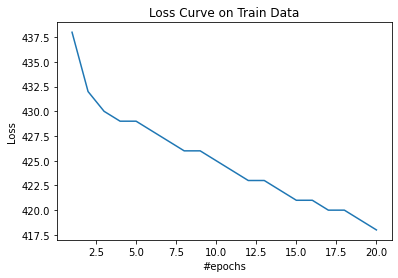

Loss values at each epoch for Train Data
1 th Iteration->LossValue =  438
2 th Iteration->LossValue =  432
3 th Iteration->LossValue =  430
4 th Iteration->LossValue =  429
5 th Iteration->LossValue =  429
6 th Iteration->LossValue =  428
7 th Iteration->LossValue =  427
8 th Iteration->LossValue =  426
9 th Iteration->LossValue =  426
10 th Iteration->LossValue =  425
11 th Iteration->LossValue =  424
12 th Iteration->LossValue =  423
13 th Iteration->LossValue =  423
14 th Iteration->LossValue =  422
15 th Iteration->LossValue =  421
16 th Iteration->LossValue =  421
17 th Iteration->LossValue =  420
18 th Iteration->LossValue =  420
19 th Iteration->LossValue =  419
20 th Iteration->LossValue =  418


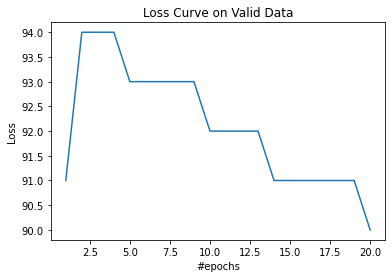

Loss values at each epoch for Valid Data
1 th Iteration->LossValue =  91
2 th Iteration->LossValue =  94
3 th Iteration->LossValue =  94
4 th Iteration->LossValue =  94
5 th Iteration->LossValue =  93
6 th Iteration->LossValue =  93
7 th Iteration->LossValue =  93
8 th Iteration->LossValue =  93
9 th Iteration->LossValue =  93
10 th Iteration->LossValue =  92
11 th Iteration->LossValue =  92
12 th Iteration->LossValue =  92
13 th Iteration->LossValue =  92
14 th Iteration->LossValue =  91
15 th Iteration->LossValue =  91
16 th Iteration->LossValue =  91
17 th Iteration->LossValue =  91
18 th Iteration->LossValue =  91
19 th Iteration->LossValue =  91
20 th Iteration->LossValue =  90

Review Classification Accuracy on Test Data =  61.20  %
------------------------------------------------------------------------------
Case 9: BatchSize = 128 and Learning Rate = 0.1


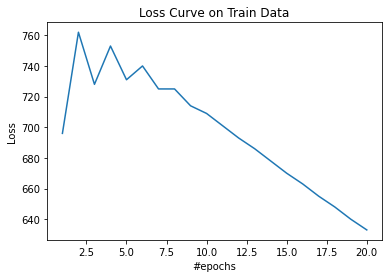

Loss values at each epoch for Train Data
1 th Iteration->LossValue =  696
2 th Iteration->LossValue =  762
3 th Iteration->LossValue =  728
4 th Iteration->LossValue =  753
5 th Iteration->LossValue =  731
6 th Iteration->LossValue =  740
7 th Iteration->LossValue =  725
8 th Iteration->LossValue =  725
9 th Iteration->LossValue =  714
10 th Iteration->LossValue =  709
11 th Iteration->LossValue =  701
12 th Iteration->LossValue =  693
13 th Iteration->LossValue =  686
14 th Iteration->LossValue =  678
15 th Iteration->LossValue =  670
16 th Iteration->LossValue =  663
17 th Iteration->LossValue =  655
18 th Iteration->LossValue =  648
19 th Iteration->LossValue =  640
20 th Iteration->LossValue =  633


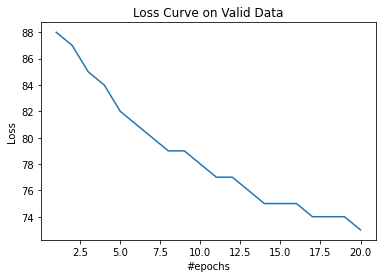

Loss values at each epoch for Valid Data
1 th Iteration->LossValue =  88
2 th Iteration->LossValue =  87
3 th Iteration->LossValue =  85
4 th Iteration->LossValue =  84
5 th Iteration->LossValue =  82
6 th Iteration->LossValue =  81
7 th Iteration->LossValue =  80
8 th Iteration->LossValue =  79
9 th Iteration->LossValue =  79
10 th Iteration->LossValue =  78
11 th Iteration->LossValue =  77
12 th Iteration->LossValue =  77
13 th Iteration->LossValue =  76
14 th Iteration->LossValue =  75
15 th Iteration->LossValue =  75
16 th Iteration->LossValue =  75
17 th Iteration->LossValue =  74
18 th Iteration->LossValue =  74
19 th Iteration->LossValue =  74
20 th Iteration->LossValue =  73

Review Classification Accuracy on Test Data =  54.00  %
------------------------------------------------------------------------------


In [28]:
k = 0
for bs in batchSizeList:
    for lr in LRList:
        k += 1
        print("Case " + str(k) + ": BatchSize = " + str(bs) +" and Learning Rate = " + str(lr))
        tempObj = LogisticRegession(epochs,bs,lr)
        tempObj.fit()
        tempObj.plotLossCurve(tempObj.lossTrain,0)
        tempObj.showLossValues(0)
        tempObj.plotLossCurve(tempObj.lossValid,1)
        tempObj.showLossValues(1)
        tempObj.predict()
        print("------------------------------------------------------------------------------")

# Part D

Case 1: BatchSize = 32 and Learning Rate = 0.001 and Regularization Coefficient = 0.01


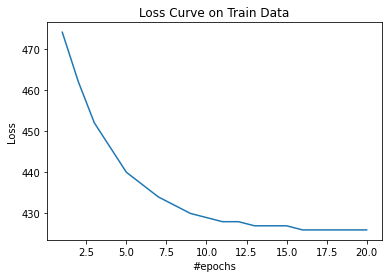

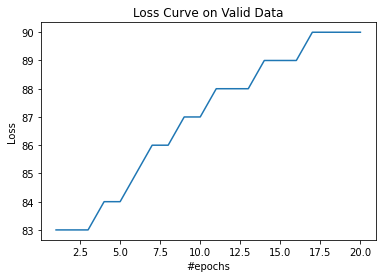


Review Classification Accuracy on Test Data =  61.20  %
------------------------------------------------------------------------------
Case 2: BatchSize = 32 and Learning Rate = 0.001 and Regularization Coefficient = 0.1


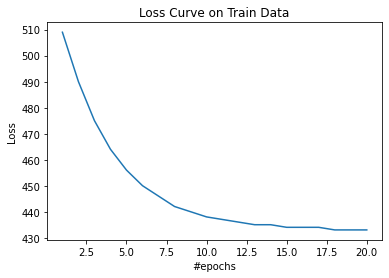

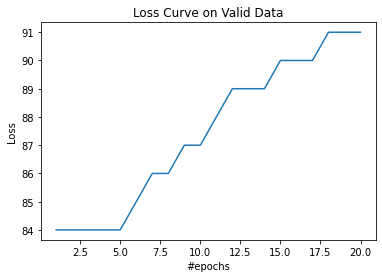


Review Classification Accuracy on Test Data =  60.80  %
------------------------------------------------------------------------------
Case 3: BatchSize = 32 and Learning Rate = 0.001 and Regularization Coefficient = 1


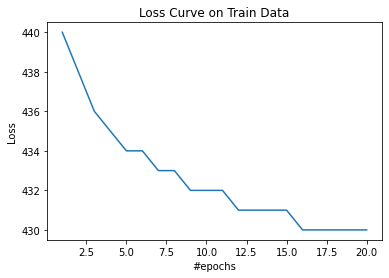

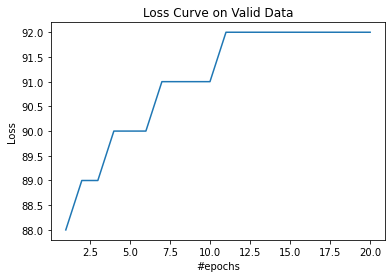


Review Classification Accuracy on Test Data =  60.80  %
------------------------------------------------------------------------------
Case 4: BatchSize = 32 and Learning Rate = 0.01 and Regularization Coefficient = 0.01


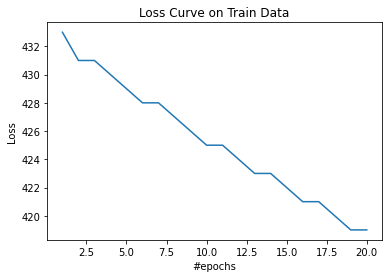

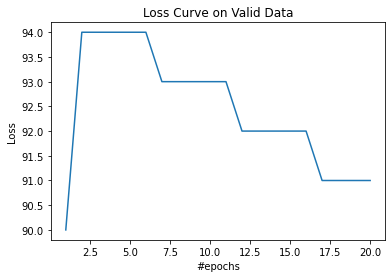


Review Classification Accuracy on Test Data =  61.20  %
------------------------------------------------------------------------------
Case 5: BatchSize = 32 and Learning Rate = 0.01 and Regularization Coefficient = 0.1


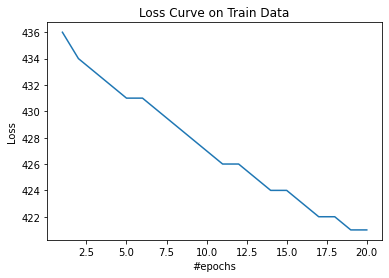

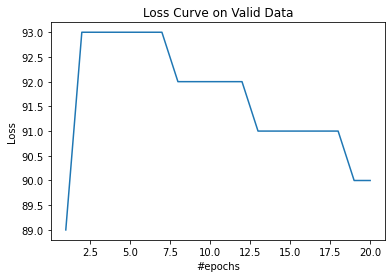


Review Classification Accuracy on Test Data =  61.20  %
------------------------------------------------------------------------------
Case 6: BatchSize = 32 and Learning Rate = 0.01 and Regularization Coefficient = 1


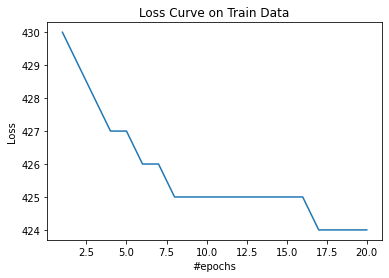

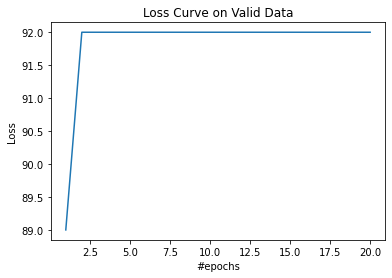


Review Classification Accuracy on Test Data =  61.20  %
------------------------------------------------------------------------------
Case 7: BatchSize = 32 and Learning Rate = 0.1 and Regularization Coefficient = 0.01


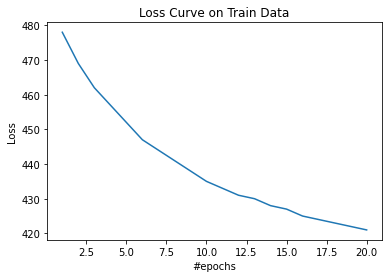

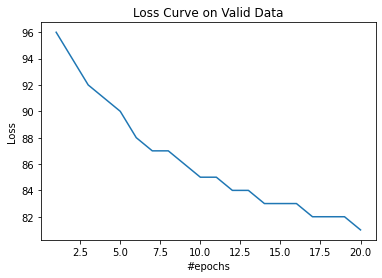


Review Classification Accuracy on Test Data =  60.80  %
------------------------------------------------------------------------------
Case 8: BatchSize = 32 and Learning Rate = 0.1 and Regularization Coefficient = 0.1


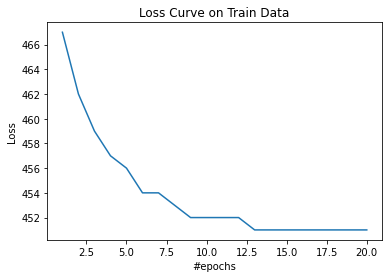

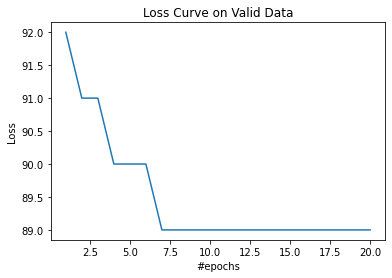


Review Classification Accuracy on Test Data =  61.20  %
------------------------------------------------------------------------------
Case 9: BatchSize = 32 and Learning Rate = 0.1 and Regularization Coefficient = 1


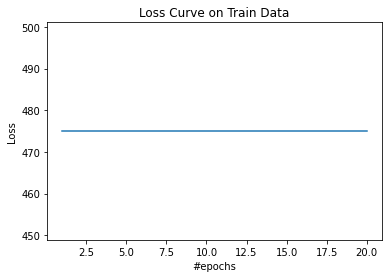

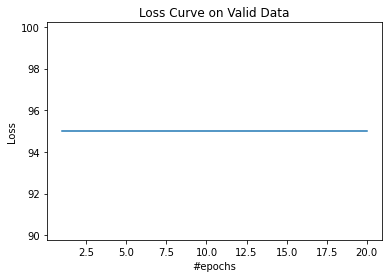


Review Classification Accuracy on Test Data =  61.20  %
------------------------------------------------------------------------------
Case 10: BatchSize = 64 and Learning Rate = 0.001 and Regularization Coefficient = 0.01


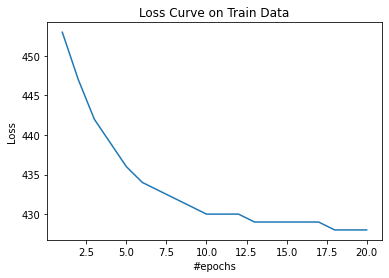

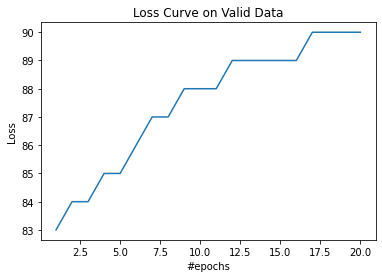


Review Classification Accuracy on Test Data =  61.20  %
------------------------------------------------------------------------------
Case 11: BatchSize = 64 and Learning Rate = 0.001 and Regularization Coefficient = 0.1


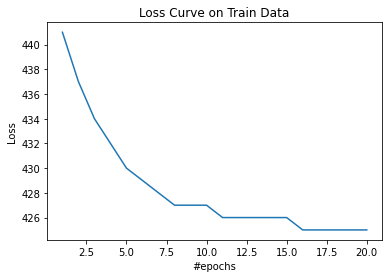

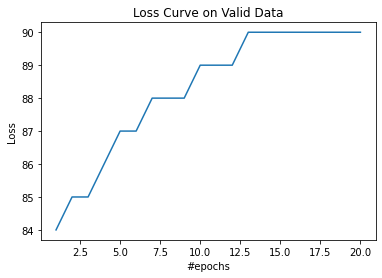


Review Classification Accuracy on Test Data =  61.20  %
------------------------------------------------------------------------------
Case 12: BatchSize = 64 and Learning Rate = 0.001 and Regularization Coefficient = 1


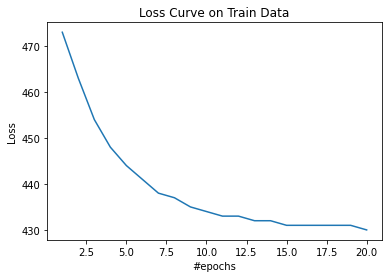

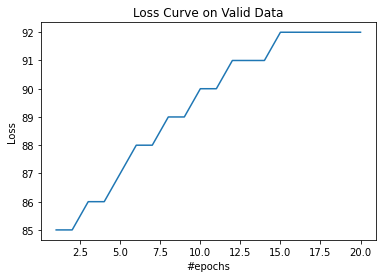


Review Classification Accuracy on Test Data =  61.20  %
------------------------------------------------------------------------------
Case 13: BatchSize = 64 and Learning Rate = 0.01 and Regularization Coefficient = 0.01


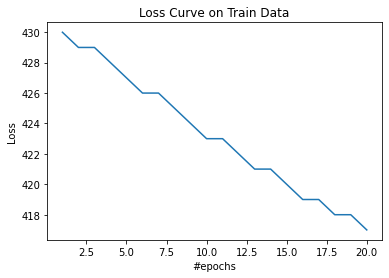

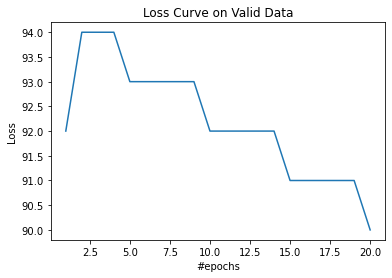


Review Classification Accuracy on Test Data =  61.20  %
------------------------------------------------------------------------------
Case 14: BatchSize = 64 and Learning Rate = 0.01 and Regularization Coefficient = 0.1


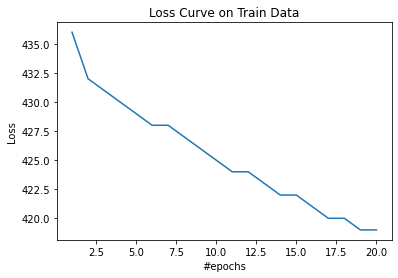

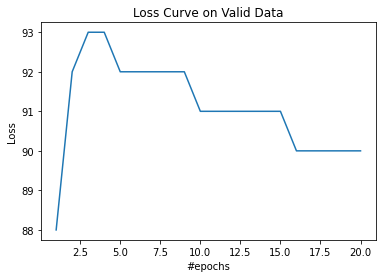


Review Classification Accuracy on Test Data =  61.20  %
------------------------------------------------------------------------------
Case 15: BatchSize = 64 and Learning Rate = 0.01 and Regularization Coefficient = 1


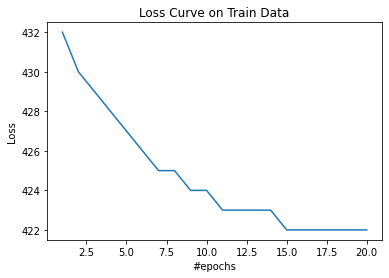

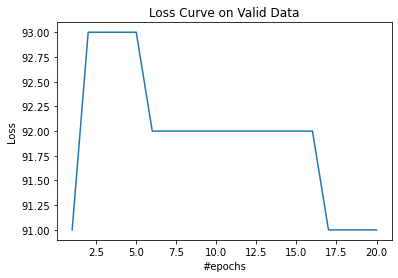


Review Classification Accuracy on Test Data =  61.20  %
------------------------------------------------------------------------------
Case 16: BatchSize = 64 and Learning Rate = 0.1 and Regularization Coefficient = 0.01


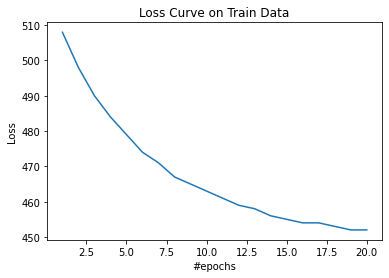

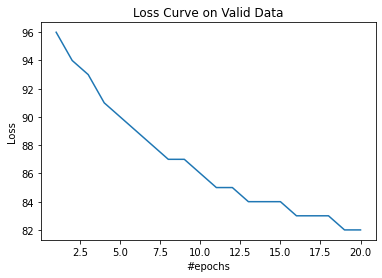


Review Classification Accuracy on Test Data =  61.20  %
------------------------------------------------------------------------------
Case 17: BatchSize = 64 and Learning Rate = 0.1 and Regularization Coefficient = 0.1


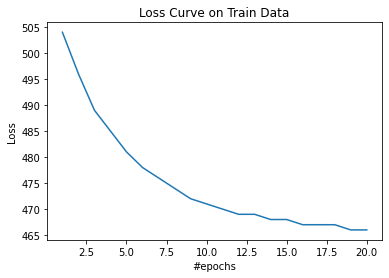

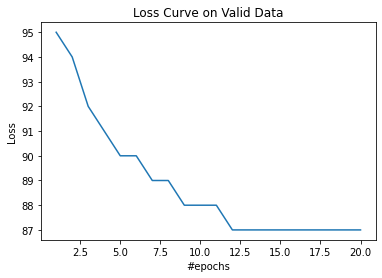


Review Classification Accuracy on Test Data =  61.20  %
------------------------------------------------------------------------------
Case 18: BatchSize = 64 and Learning Rate = 0.1 and Regularization Coefficient = 1


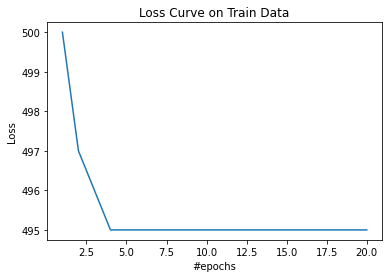

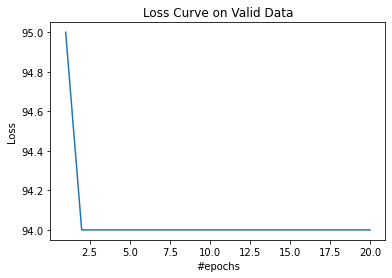


Review Classification Accuracy on Test Data =  61.20  %
------------------------------------------------------------------------------
Case 19: BatchSize = 128 and Learning Rate = 0.001 and Regularization Coefficient = 0.01


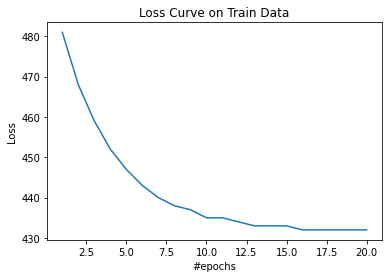

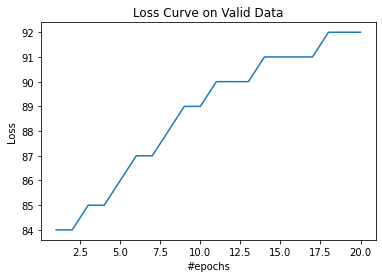


Review Classification Accuracy on Test Data =  60.80  %
------------------------------------------------------------------------------
Case 20: BatchSize = 128 and Learning Rate = 0.001 and Regularization Coefficient = 0.1


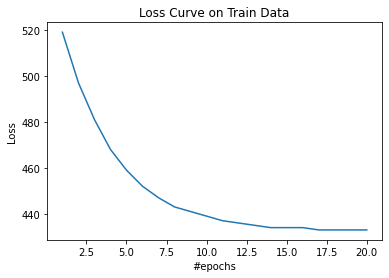

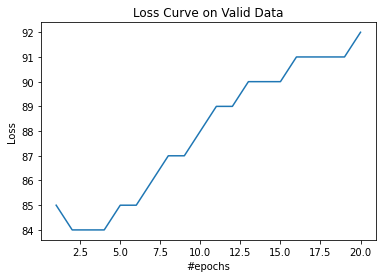


Review Classification Accuracy on Test Data =  59.60  %
------------------------------------------------------------------------------
Case 21: BatchSize = 128 and Learning Rate = 0.001 and Regularization Coefficient = 1


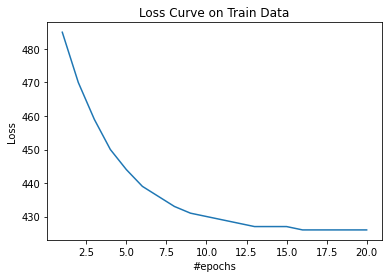

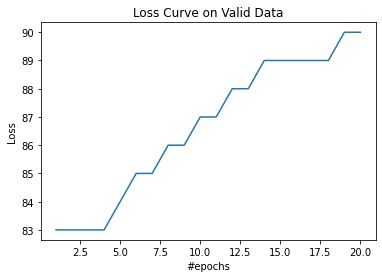


Review Classification Accuracy on Test Data =  60.80  %
------------------------------------------------------------------------------
Case 22: BatchSize = 128 and Learning Rate = 0.01 and Regularization Coefficient = 0.01


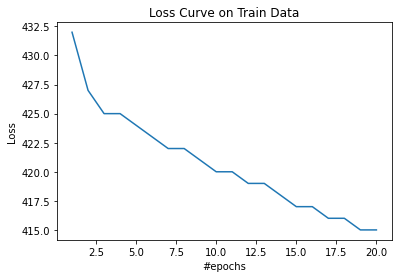

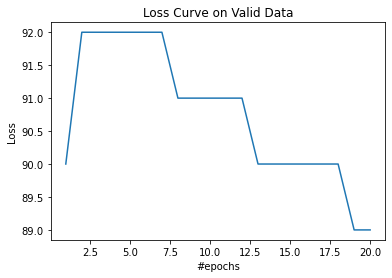


Review Classification Accuracy on Test Data =  60.80  %
------------------------------------------------------------------------------
Case 23: BatchSize = 128 and Learning Rate = 0.01 and Regularization Coefficient = 0.1


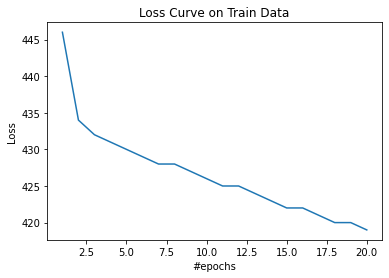

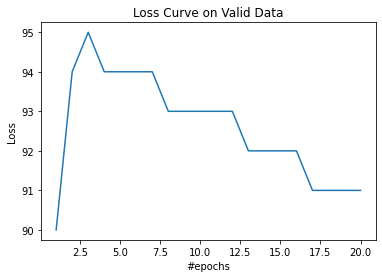


Review Classification Accuracy on Test Data =  61.20  %
------------------------------------------------------------------------------
Case 24: BatchSize = 128 and Learning Rate = 0.01 and Regularization Coefficient = 1


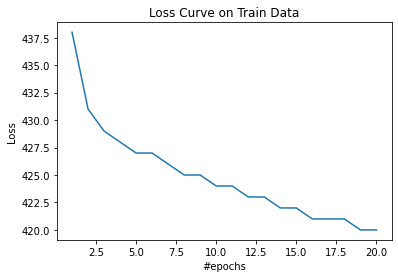

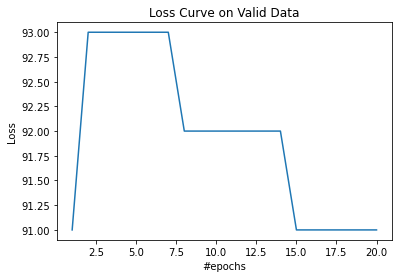


Review Classification Accuracy on Test Data =  61.20  %
------------------------------------------------------------------------------
Case 25: BatchSize = 128 and Learning Rate = 0.1 and Regularization Coefficient = 0.01


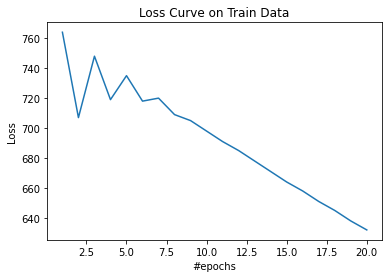

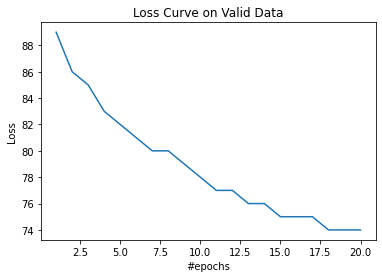


Review Classification Accuracy on Test Data =  54.00  %
------------------------------------------------------------------------------
Case 26: BatchSize = 128 and Learning Rate = 0.1 and Regularization Coefficient = 0.1


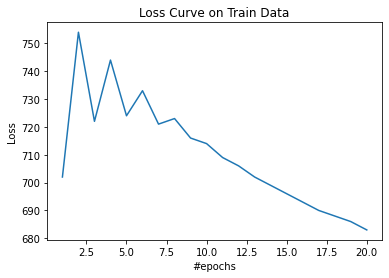

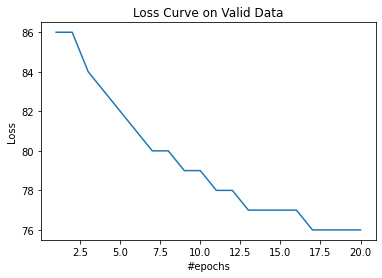


Review Classification Accuracy on Test Data =  55.60  %
------------------------------------------------------------------------------
Case 27: BatchSize = 128 and Learning Rate = 0.1 and Regularization Coefficient = 1


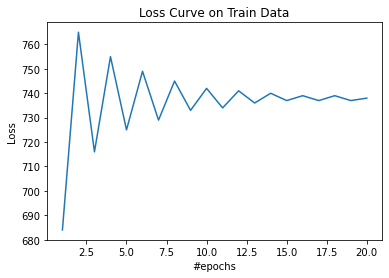

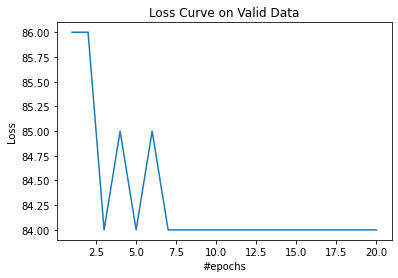


Review Classification Accuracy on Test Data =  60.80  %
------------------------------------------------------------------------------


In [29]:
RCList = [1e-2, 1e-1, 1]
k = 0
for bs in batchSizeList:
    for lr in LRList:
        for rc in RCList:
            k += 1
            print("Case " + str(k) + ": BatchSize = " + str(bs) +" and Learning Rate = " + str(lr) + " and Regularization Coefficient = " + str(rc))
            DtempObj = LogisticRegession(epochs,bs,lr,rc)
            DtempObj.fit(1)
            DtempObj.plotLossCurve(DtempObj.lossTrain,0)
            DtempObj.plotLossCurve(DtempObj.lossValid,1)
            DtempObj.predict()
            print("------------------------------------------------------------------------------")